### From raw text to word embeddings

Word embeddings are a popular and powerful way to associate a vector with a word using dense word vectors. Word embeddings are meant to map human language into a geometric space.

#### Processing the labels of the raw IMDB 🎥 data

[Download the IMDB reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and uncompress it into your working directory.

Let’s collect the individual training reviews into a list of strings, one string per review. We’ll also collect the review labels (positive/negative) into a labels list.

In [1]:
import os

imdb_dir = '/src/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### Tokenizing the text of the raw IMDB data

Let’s vectorize the text and prepare a training and validation split. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available we'll restrict the training data to the first 200 samples.

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### Preprocessing the embeddings with GloVe

GloVe is a precomputed databases of word embeddings which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data. [Download GloVe pre-trained word vectors](http://nlp.stanford.edu/data/glove.6B.zip) and uncompress it into your working directory.

In [3]:
glove_dir = '/src/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### Preparing the GloVe word-embeddings matrix

Next, we’ll build an embedding matrix that we can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index (built during tokenization).

In [4]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Defining a model

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. It’s effectively a dictionary lookup.

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### Loading pretrained word embeddings into the Embedding layer

We’ll freeze the Embedding layer (set its trainable attribute to False). When parts of a model are pretrained (like our Embedding layer) and parts are randomly initialized (like our classifier), the pretrained parts shouldn’t be updated during training, to avoid forgetting what they already know. The large gradient updates triggered by the randomly initialized layers would be disruptive to the already-learned features.

In [6]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### Training and evaluation

In [7]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.0744 - acc: 0.4850 - val_loss: 0.6934 - val_acc: 0.4963
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.8727 - acc: 0.5850 - val_loss: 0.7023 - val_acc: 0.5255
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4771 - acc: 0.8150 - val_loss: 0.9828 - val_acc: 0.5100
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4881 - acc: 0.7350 - val_loss: 0.6849 - val_acc: 0.5660
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2567 - acc: 0.9400 - val_loss: 0.8428 - val_acc: 0.5239
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2190 - acc: 0.9350 - val_loss: 0.7070 - val_acc: 0.5638
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1566 - acc: 0.9600 - val_loss: 1.0488 - val_acc: 0.4965
Epoch 8/10
200/200 [========

#### Plotting the results

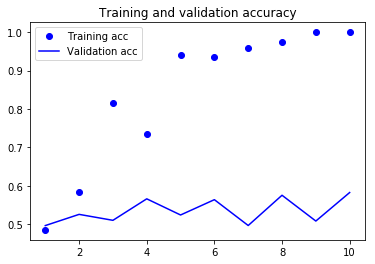

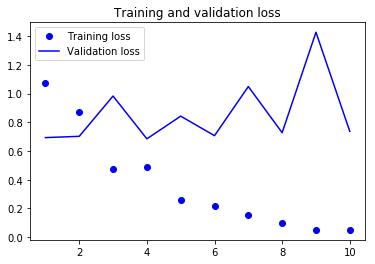

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy has high variance for the same reason, but it seems to reach the high 50s. Because we have so few training samples, performance is heavily dependent on exactly which 200 samples we choose—and we’re choosing them at random.

#### Evaluate the model on the test data

First, you need to tokenize the test data.

In [10]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Next, let's load and evaluate the model.

In [11]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 45us/step


[0.7377652863121033, 0.57496]

We get an appalling test accuracy of 57%. Working with just a handful of training samples is difficult!